In [2]:
import numpy as np 
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from captum.attr import FeaturePermutation

c:\Users\jlian\Projects\DiAGE\nn\venv_DiAge\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set device to gpu if you have one 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce RTX 2060 with Max-Q Design


In [5]:
#df = pd.read_csv('../ProcessedData/SRR_AllGex_Normal.csv')
df = pd.read_csv('../ProcessedData/SRR_AllGex_HfatDiet.csv')
df['Notes'].value_counts()

Notes
HfatDiet    91
Name: count, dtype: int64

In [8]:
df.value_counts(['Tissue', 'Sex'])

Tissue  Sex   
Heads   Female    24
Bodies  Female    23
        Male      22
Heads   Male      22
Name: count, dtype: int64

In [12]:
# drop unrelated columns 
drop_list = ['Sample_run', 'LoadDate', 'spots', 'bases', 'avgLength', 'size_MB', 'Experiment', 'LibraryStrategy', 'LibraryLayout', 'Platform', 'SRAStudy', 'BioProject', 'Sample', 'BioSample', 'Notes', 'GSM', 'NA']
df.drop(drop_list, axis=1, inplace=True)
df

,Age,Sex,Tissue,128up,14-3-3epsilon,14-3-3zeta,140up,18w,26-29-p,2mit,...,zormin,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx
0,9.5,Male,Bodies,40.8707,297.9644,406.736710,16.23760,6.18446,91.9435,0.521302,...,29.136503,1.258820,5.62031,0.294969,72.6733,7.76584,3.747130,8.801270,0.207499,41.03116
1,9.5,Male,Bodies,38.0673,310.2855,400.749720,14.51230,5.45057,88.0330,0.892673,...,29.198760,0.000000,7.78291,0.539543,70.4300,9.15381,4.058230,7.484777,0.000000,43.92670
2,9.5,Male,Bodies,37.3129,309.3876,418.976952,19.66452,5.80695,86.7101,0.618905,...,29.337660,1.565550,6.98176,0.294946,73.8292,6.91619,4.162770,5.882890,0.165962,41.33510
3,9.5,Male,Bodies,44.3608,302.9485,400.887500,16.22820,5.51788,94.6138,0.747150,...,29.888751,2.009780,8.15853,0.294629,67.1585,9.28073,4.846540,6.460722,0.082759,42.85289
4,9.5,Male,Bodies,48.6124,298.4391,388.528044,15.46850,4.58643,101.3240,0.712724,...,30.777180,1.114990,5.25975,0.588728,70.2078,7.42548,4.162730,5.404898,0.123808,42.22020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,9.5,Female,Heads,31.4388,546.1177,1123.659160,33.58480,22.73590,144.9040,12.827000,...,37.841310,0.710275,16.76460,0.000000,47.4042,10.98200,0.000000,80.084370,0.131760,177.78225
87,9.5,Female,Heads,32.9058,530.3140,1093.570410,20.01392,20.35240,135.2930,16.398500,...,38.442800,0.000000,14.00550,0.000000,39.8521,12.36140,0.000000,74.954206,0.000000,173.30782
88,9.5,Female,Heads,29.9697,536.5327,1098.805210,20.54820,21.26760,129.8000,15.431500,...,37.443624,0.621093,11.81450,0.000000,39.2137,14.05540,0.192466,84.945930,0.114958,160.53367
89,9.5,Female,Heads,34.9537,533.2641,1077.198400,23.59030,23.14880,135.0690,15.833000,...,38.516620,0.309562,16.96220,0.000000,40.1536,10.71440,0.000000,81.718700,0.286495,167.81738


In [13]:
# one-hot encoding for sex and tissue
index = df.columns.get_loc('Sex')
encoded = pd.get_dummies(df['Sex'], prefix='Sex')
df = df.drop('Sex', axis=1)
for i, col in enumerate(encoded.columns):
    df.insert(index + i, col, encoded[col])

index = df.columns.get_loc('Tissue')
encoded = pd.get_dummies(df['Tissue'], prefix='Tissue')
df = df.drop('Tissue', axis=1)
for i, col in enumerate(encoded.columns):
    df.insert(index + i, col, encoded[col])

df

,Age,Sex_Female,Sex_Male,Tissue_Bodies,Tissue_Heads,128up,14-3-3epsilon,14-3-3zeta,140up,18w,...,zormin,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx
0,9.5,False,True,True,False,40.8707,297.9644,406.736710,16.23760,6.18446,...,29.136503,1.258820,5.62031,0.294969,72.6733,7.76584,3.747130,8.801270,0.207499,41.03116
1,9.5,False,True,True,False,38.0673,310.2855,400.749720,14.51230,5.45057,...,29.198760,0.000000,7.78291,0.539543,70.4300,9.15381,4.058230,7.484777,0.000000,43.92670
2,9.5,False,True,True,False,37.3129,309.3876,418.976952,19.66452,5.80695,...,29.337660,1.565550,6.98176,0.294946,73.8292,6.91619,4.162770,5.882890,0.165962,41.33510
3,9.5,False,True,True,False,44.3608,302.9485,400.887500,16.22820,5.51788,...,29.888751,2.009780,8.15853,0.294629,67.1585,9.28073,4.846540,6.460722,0.082759,42.85289
4,9.5,False,True,True,False,48.6124,298.4391,388.528044,15.46850,4.58643,...,30.777180,1.114990,5.25975,0.588728,70.2078,7.42548,4.162730,5.404898,0.123808,42.22020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,9.5,True,False,False,True,31.4388,546.1177,1123.659160,33.58480,22.73590,...,37.841310,0.710275,16.76460,0.000000,47.4042,10.98200,0.000000,80.084370,0.131760,177.78225
87,9.5,True,False,False,True,32.9058,530.3140,1093.570410,20.01392,20.35240,...,38.442800,0.000000,14.00550,0.000000,39.8521,12.36140,0.000000,74.954206,0.000000,173.30782
88,9.5,True,False,False,True,29.9697,536.5327,1098.805210,20.54820,21.26760,...,37.443624,0.621093,11.81450,0.000000,39.2137,14.05540,0.192466,84.945930,0.114958,160.53367
89,9.5,True,False,False,True,34.9537,533.2641,1077.198400,23.59030,23.14880,...,38.516620,0.309562,16.96220,0.000000,40.1536,10.71440,0.000000,81.718700,0.286495,167.81738


In [14]:
# add empty columns to match shape of original dataset

df_normal = pd.read_csv('../ProcessedData/SRR_AllGex_Normal.csv')
df_normal.drop(drop_list, axis=1, inplace=True)

# one-hot encoding for sex and tissue
index = df_normal.columns.get_loc('Sex')
encoded = pd.get_dummies(df_normal['Sex'], prefix='Sex')
df_normal = df_normal.drop('Sex', axis=1)
for i, col in enumerate(encoded.columns):
    df_normal.insert(index + i, col, encoded[col])

index = df_normal.columns.get_loc('Tissue')
encoded = pd.get_dummies(df_normal['Tissue'], prefix='Tissue')
df_normal = df_normal.drop('Tissue', axis=1)
for i, col in enumerate(encoded.columns):
    df_normal.insert(index + i, col, encoded[col])

# determine missing columns in encoding and fill with 'False'
missing_columns = set(df_normal.columns) - set(df.columns)
for col in missing_columns:
    df[col] = False
df = df[df_normal.columns]
df

,Age,Sex_Female,Sex_Male,Sex_Unknown,Sex_mixed,Tissue_Bodies,Tissue_Brain,Tissue_Brains,Tissue_Head,Tissue_Heads,...,zormin,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx
0,9.5,False,True,False,False,True,False,False,False,False,...,29.136503,1.258820,5.62031,0.294969,72.6733,7.76584,3.747130,8.801270,0.207499,41.03116
1,9.5,False,True,False,False,True,False,False,False,False,...,29.198760,0.000000,7.78291,0.539543,70.4300,9.15381,4.058230,7.484777,0.000000,43.92670
2,9.5,False,True,False,False,True,False,False,False,False,...,29.337660,1.565550,6.98176,0.294946,73.8292,6.91619,4.162770,5.882890,0.165962,41.33510
3,9.5,False,True,False,False,True,False,False,False,False,...,29.888751,2.009780,8.15853,0.294629,67.1585,9.28073,4.846540,6.460722,0.082759,42.85289
4,9.5,False,True,False,False,True,False,False,False,False,...,30.777180,1.114990,5.25975,0.588728,70.2078,7.42548,4.162730,5.404898,0.123808,42.22020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,9.5,True,False,False,False,False,False,False,False,True,...,37.841310,0.710275,16.76460,0.000000,47.4042,10.98200,0.000000,80.084370,0.131760,177.78225
87,9.5,True,False,False,False,False,False,False,False,True,...,38.442800,0.000000,14.00550,0.000000,39.8521,12.36140,0.000000,74.954206,0.000000,173.30782
88,9.5,True,False,False,False,False,False,False,False,True,...,37.443624,0.621093,11.81450,0.000000,39.2137,14.05540,0.192466,84.945930,0.114958,160.53367
89,9.5,True,False,False,False,False,False,False,False,True,...,38.516620,0.309562,16.96220,0.000000,40.1536,10.71440,0.000000,81.718700,0.286495,167.81738


In [15]:
class Data(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [17]:
# split data into training and validation, scale data
# X = df.drop(columns=['Age'])
# y = df['Age']

# X = X.astype('float64') # when not using standard scaler

MH = df[(df['Sex_Male'] == True) & (df['Tissue_Heads'] == True)]
MB = df[(df['Sex_Male'] == True) & (df['Tissue_Bodies'] == True)]
FH = df[(df['Sex_Female'] == True) & (df['Tissue_Heads'] == True)]
FB = df[(df['Sex_Female'] == True) & (df['Tissue_Bodies'] == True)]

MH_X = MH.drop(columns=['Age']).astype('float64')
MB_X = MB.drop(columns=['Age']).astype('float64')
FH_X = FH.drop(columns=['Age']).astype('float64')
FB_X = FB.drop(columns=['Age']).astype('float64')
MH_y = MH['Age']
MB_y = MB['Age']
FH_y = FH['Age']
FB_y = FB['Age']

# testing no scaling
MH_X_tensor = torch.tensor(MH_X.values, dtype=torch.float32)
MH_y_tensor = torch.tensor(MH_y.values, dtype=torch.float32).view(-1, 1)
MB_X_tensor = torch.tensor(MB_X.values, dtype=torch.float32)
MB_y_tensor = torch.tensor(MB_y.values, dtype=torch.float32).view(-1, 1)
FH_X_tensor = torch.tensor(FH_X.values, dtype=torch.float32)
FH_y_tensor = torch.tensor(FH_y.values, dtype=torch.float32).view(-1, 1)
FB_X_tensor = torch.tensor(FB_X.values, dtype=torch.float32)
FB_y_tensor = torch.tensor(FB_y.values, dtype=torch.float32).view(-1, 1)

MH_valid_data = Data(MH_X_tensor, MH_y_tensor)
MB_valid_data = Data(MB_X_tensor, MB_y_tensor)
FH_valid_data = Data(FH_X_tensor, FH_y_tensor)
FB_valid_data = Data(FB_X_tensor, FB_y_tensor)

batch_size = 32

MH_valid_loader = DataLoader(MH_valid_data, batch_size)
MB_valid_loader = DataLoader(MB_valid_data, batch_size)
FH_valid_loader = DataLoader(FH_valid_data, batch_size)
FB_valid_loader = DataLoader(FB_valid_data, batch_size)

C:\Users\jlian\AppData\Local\Temp\ipykernel_33092\957607681.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
C:\Users\jlian\AppData\Local\Temp\ipykernel_33092\957607681.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(targets, dtype=torch.float32)


In [18]:
model = nn.Sequential(
    nn.Linear(13676, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8,1)
)

model_file = '2.42 2024-10-23 16_51' # ex/ '3.3 2024-10-30 15_51'
model.load_state_dict(torch.load(f'models/{model_file}.pt', weights_only=True))
model.eval()

Sequential(
  (0): Linear(in_features=13676, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=32, bias=True)
  (9): ReLU()
  (10): Linear(in_features=32, out_features=16, bias=True)
  (11): ReLU()
  (12): Linear(in_features=16, out_features=8, bias=True)
  (13): ReLU()
  (14): Linear(in_features=8, out_features=1, bias=True)
)

MSE Loss: 6.81438
RMSE Loss: 2.610435864093047


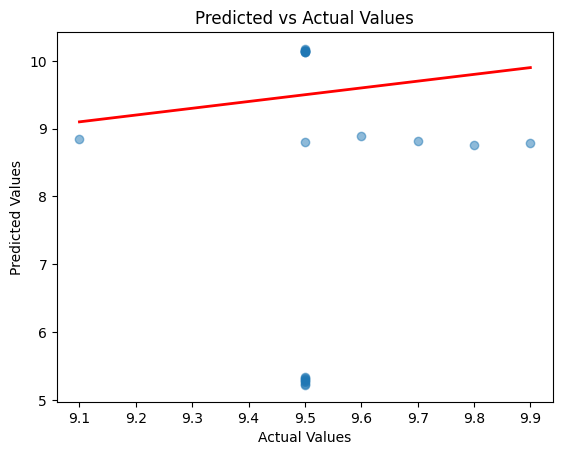

In [19]:
# validate with test data

import matplotlib.pyplot as plt

MH_y_true = []
MH_y_pred = []

RMSE = 0

with torch.no_grad():
    loss = 0
    for i, (inputs, labels) in enumerate(MH_valid_loader):
        predictions = model(inputs)
        MH_y_pred.extend(predictions.squeeze().numpy())
        MH_y_true.extend(labels.squeeze().numpy())
        loss += F.mse_loss(predictions, labels)
    print(f'MSE Loss: {loss / (i + 1):.5f}')
    print(f'RMSE Loss: {math.sqrt(loss / (i + 1))}')
    RMSE = math.sqrt(loss / (i + 1))

# Assuming `y_true` is the actual target values and `y_pred` is the predicted values
plt.scatter(MH_y_true, MH_y_pred, alpha=0.5)
plt.plot([min(MH_y_true), max(MH_y_true)], [min(MH_y_true), max(MH_y_true)], color='red', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

MSE Loss: 0.14481
RMSE Loss: 0.38053545748914286


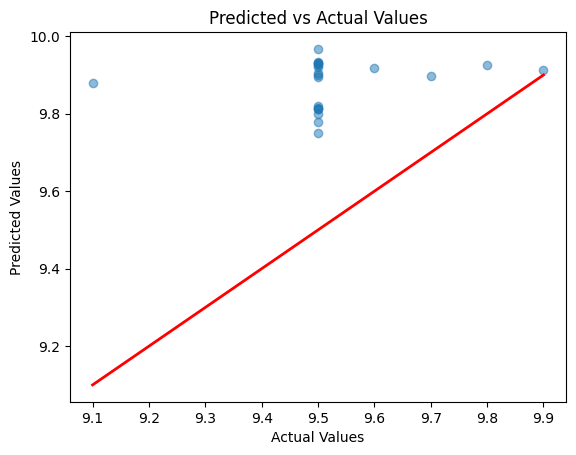

In [20]:
# validate with test data

import matplotlib.pyplot as plt

MB_y_true = []
MB_y_pred = []

RMSE = 0

with torch.no_grad():
    loss = 0
    for i, (inputs, labels) in enumerate(MB_valid_loader):
        predictions = model(inputs)
        MB_y_pred.extend(predictions.squeeze().numpy())
        MB_y_true.extend(labels.squeeze().numpy())
        loss += F.mse_loss(predictions, labels)
    print(f'MSE Loss: {loss / (i + 1):.5f}')
    print(f'RMSE Loss: {math.sqrt(loss / (i + 1))}')
    RMSE = math.sqrt(loss / (i + 1))

# Assuming `y_true` is the actual target values and `y_pred` is the predicted values
plt.scatter(MB_y_true, MB_y_pred, alpha=0.5)
plt.plot([min(MB_y_true), max(MB_y_true)], [min(MB_y_true), max(MB_y_true)], color='red', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

MSE Loss: 0.21922
RMSE Loss: 0.46821247116326276


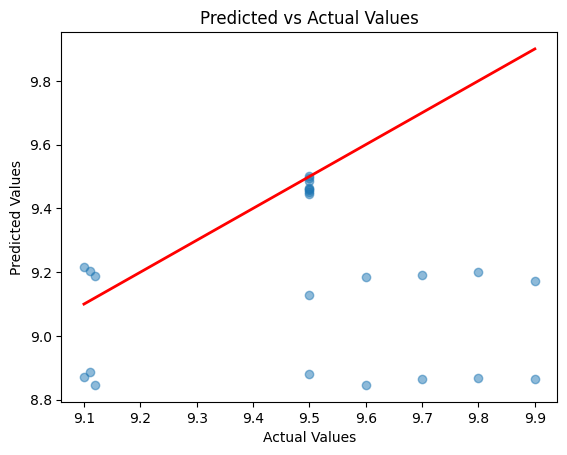

In [21]:
# validate with test data

import matplotlib.pyplot as plt

FH_y_true = []
FH_y_pred = []

RMSE = 0

with torch.no_grad():
    loss = 0
    for i, (inputs, labels) in enumerate(FH_valid_loader):
        predictions = model(inputs)
        FH_y_pred.extend(predictions.squeeze().numpy())
        FH_y_true.extend(labels.squeeze().numpy())
        loss += F.mse_loss(predictions, labels)
    print(f'MSE Loss: {loss / (i + 1):.5f}')
    print(f'RMSE Loss: {math.sqrt(loss / (i + 1))}')
    RMSE = math.sqrt(loss / (i + 1))

# Assuming `y_true` is the actual target values and `y_pred` is the predicted values
plt.scatter(FH_y_true, FH_y_pred, alpha=0.5)
plt.plot([min(FH_y_true), max(FH_y_true)], [min(FH_y_true), max(FH_y_true)], color='red', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

MSE Loss: 0.24511
RMSE Loss: 0.49508672917747837


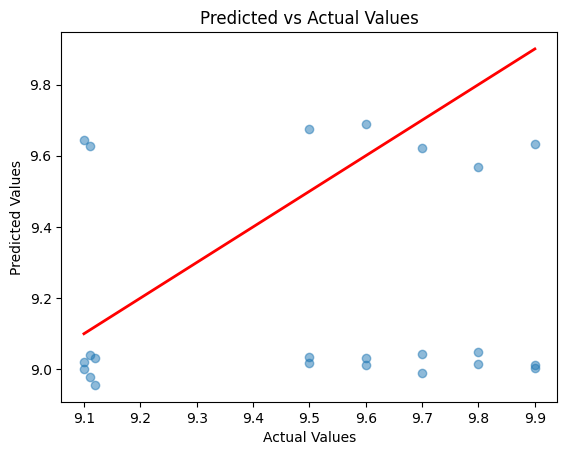

In [22]:
# validate with test data

import matplotlib.pyplot as plt

FB_y_true = []
FB_y_pred = []

RMSE = 0

with torch.no_grad():
    loss = 0
    for i, (inputs, labels) in enumerate(FB_valid_loader):
        predictions = model(inputs)
        FB_y_pred.extend(predictions.squeeze().numpy())
        FB_y_true.extend(labels.squeeze().numpy())
        loss += F.mse_loss(predictions, labels)
    print(f'MSE Loss: {loss / (i + 1):.5f}')
    print(f'RMSE Loss: {math.sqrt(loss / (i + 1))}')
    RMSE = math.sqrt(loss / (i + 1))

# Assuming `y_true` is the actual target values and `y_pred` is the predicted values
plt.scatter(FB_y_true, FB_y_pred, alpha=0.5)
plt.plot([min(FB_y_true), max(FB_y_true)], [min(FB_y_true), max(FB_y_true)], color='red', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()